In [193]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated, Optional
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
import operator

In [194]:
generator_llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.7
)

evaluator_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

optimizer_llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.4
)

In [195]:
class TweetState(TypedDict):
    topic: str
    tweet: str 
    evaluation: Literal["approved", "requires_improvement"]
    feedback: str
    iteration: int
    max_iterations: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]



In [196]:
class EvaluationSchema(BaseModel):

    evaluation: Literal["approved", "requires_improvement"] = Field(
        description="Decision: approved if tweet meets all criteria, otherwise requires_improvement."
    )

    feedback: str = Field(
        description=(
            "Always provide 1-2 short sentences of concrete feedback. "
            "If approved, say what is strong and one optional minor improvement. "
            "If requires_improvement, say the biggest weakness and the exact fix. "
            "Keep feedback concise so it can be used in the optimizer."
        ),
        max_length=240
    )

    clarity_score: int = Field(
        description="1-10 score for clarity.",
        ge=1,
        le=10
    )

    engagement_score: int = Field(
        description="1-10 score for engagement.",
        ge=1,
        le=10
    )

    relevance_score: int = Field(
        description="1-10 score for relevance to modern AI.",
        ge=1,
        le=10
    )

structured_evaluation = evaluator_llm.with_structured_output(EvaluationSchema)

In [197]:
def generator(state: TweetState):

    # Prompt for the generator
    pmessages = [

        SystemMessage(
            content="You are a knowledgeable AI engineer who writes engaging posts on X about modern AI topics."
        ),

        HumanMessage(
            content=f"""
                Write a short, original tweet about this topic:

                Topic: "{state['topic']}"

                Rules:

                - Maximum 280 characters
                - Sound like a real AI developer on X
                - Focus on current AI trends (LLMs, agents, automation, ML, AI tools)
                - Use simple everyday English
                - One clear idea
                - No question-answer format
                - No emojis unless natural
                - Make it insightful or relatable
                - This is version {state['iteration']+ 1} of {state['max_iterations']}
            """
        )
    ]

    #send the prompt to the generator LLM
    response = generator_llm.invoke(pmessages).content.strip()


    #return the generated tweet and the topic in the state
    return {
        "tweet": response,
        "tweet_history":[response]
    }

In [198]:
def evaluator(state: TweetState):

    # Prompt for the evaluator
    pmessages = [
        SystemMessage(
            content=(
                "You are a strict reviewer of AI-related tweets for X. "
                "You prioritize specificity, clarity, and modern AI relevance. "
                "You are conservative with approvals."
            )
        ),
         HumanMessage(
            content=f"""
                Evaluate this tweet.

                Tweet:
                {state['tweet']}

                Criteria:

                1. Clarity
                - Easy to understand on first read
                - No vague phrases without specifics

                2. Engagement
                - Strong hook in the first line
                - Sounds like a real AI developer post, not generic marketing

                3. Relevance to modern AI
                - Must mention at least ONE concrete modern AI element:
                LLMs, agents, RAG, tool use, evals, fine-tuning, embeddings, vector DBs, function calling, prompt chaining

                Rules:
                - Under 280 characters
                - Prefer no hashtags
                - One clear idea

                Decision policy:
                - If iteration is {state['iteration']} and iteration <= 2, require a higher bar:
                - approve ONLY if it is exceptionally specific and has a strong hook.
                - If iteration > 2, approve if it meets all criteria normally.

                Output must match the schema exactly.

                Feedback rules (IMPORTANT):
                - Always return feedback (even if approved).
                - Keep feedback to 1-2 short sentences.
                - If approved: mention 1-2 strengths and 1 small optional improvement.
                - If requires_improvement: mention the biggest weakness and the exact fix.
                """
        )
    ]

     # This returns an EvaluationSchema instance (Pydantic object)
    result = structured_evaluation.invoke(pmessages)

    return {
        "evaluation": result.evaluation,
        "feedback": result.feedback,
        "feedback_history":[result.feedback]

    }

In [199]:
def optimizer(state: TweetState):

    pmessages = [
        SystemMessage(
            content=(
                "You are an expert X (Twitter) editor for AI/ML content. "
                "Rewrite tweets to be clearer, more engaging, and more relevant while keeping the same meaning and voice. "
                "Never add explanations, labels, or quotes. Output only the tweet text."
            )
        ),
        HumanMessage(
            content=f"""
                Task: Rewrite the tweet using the feedback.

                Constraints:
                - Keep the same topic and intent
                - Under 280 characters
                - Sound like a real AI developer on X
                - One clear idea (no thread)
                - No hashtags unless truly necessary
                - No extra commentary, output only the final tweet

                Original tweet:
                {state["tweet"]}

                Feedback:
                {state["feedback"]}
            """
        )
    ]

    response = optimizer_llm.invoke(pmessages).content

    iteration = state["iteration"] + 1

    return {"tweet": response, "iteration": iteration, "tweet_history":[response]}

In [200]:
def router(state: TweetState):

    if state["evaluation"] == "approved" or state["iteration"] >= state["max_iterations"]:
        return "approved"
    else:
        return "requires_improvement"

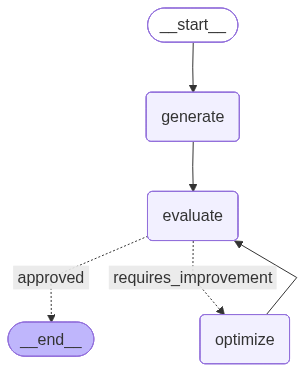

In [201]:
graph = StateGraph(TweetState)

#add the nodes to the graph
graph.add_node('generate', generator)
graph.add_node('evaluate', evaluator)
graph.add_node('optimize', optimizer)

#add the edges to the graph
graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')
graph.add_conditional_edges('evaluate', router, {
    "approved": END,
    "requires_improvement": 'optimize'
})
graph.add_edge('optimize', 'evaluate')


#complie the graph into a workflow that can be executed
workflow = graph.compile()

from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())


In [202]:
initial_state = {
    "topic" : "ABCD",
    "iteration": 0,
    "max_iterations": 5
}

workflow.invoke(initial_state)


/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EvaluationSchema(evaluati...re=7, relevance_score=5), input_type=EvaluationSchema])
  return self.__pydantic_serializer__.to_python(
/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EvaluationSchema(evaluati...re=6, relevance_score=7), input_type=EvaluationSchema])
  return self.__pydantic_serializer__.to_python(
/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `

{'topic': 'ABCD',
 'tweet': "Discovering Advanced Business Contextual Data (ABCD) in AI feels like unlocking a new level. While LLMs and agents automate tasks, ABCD streamlines data processing, boosting AI accessibility. Picture optimizing supply chains with instant insights—it's a game-changer for innovation!",
 'evaluation': 'approved',
 'feedback': 'The tweet effectively highlights the significance of ABCD in AI while mentioning LLMs, making it relevant and engaging. Consider tightening the phrasing for even greater clarity.',
 'iteration': 4,
 'max_iterations': 5,
 'tweet_history': ['Diving into "ABCD" in the AI world today feels like unlocking a new level in gaming. Just like how LLMs and agents automate tasks, ABCD pushes boundaries, streamlining complex processes and opening doors to innovation. It\'s the next step in making AI even more accessible and powerful! #AI #Innovation',
  'Exploring "ABCD" in AI today feels like leveling up in gaming. Similar to how LLMs and agents aut